
# RNN Exercise

**TASK: IMPORT THE BASIC LIBRARIES YOU THINK YOU WILL USE**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


## Data

Info about this data set: https://fred.stlouisfed.org/series/IPN31152N


Units:  Index 2012=100, Not Seasonally Adjusted

Frequency:  Monthly

The industrial production (IP) index measures the real output of all relevant establishments located in the United States, regardless of their ownership, but not those located in U.S. territories.

NAICS = 31152

Source Code: IP.N31152.N

Suggested Citation:
Board of Governors of the Federal Reserve System (US), Industrial Production: Nondurable Goods: Ice cream and frozen dessert [IPN31152N], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/IPN31152N, November 16, 2019.

# Project Tasks

**TASK: Read in the data set "Frozen_Dessert_Production.csv" from the Data folder. Figure out how to set the date to a datetime index columns**

In [5]:
# CODE HERE
df=pd.read_csv("/content/Frozen_Dessert_Production.csv",index_col='DATE')

In [6]:
df.head()

,IPN31152N
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**Task: Change the column name to Production**

In [8]:
#CODE HERE
df.rename(columns = {'IPN31152N':'Production'}, inplace = True)

In [9]:
df.head()

,Production
DATE,
1972-01-01,59.9622
1972-02-01,67.0605
1972-03-01,74.2350
1972-04-01,78.1120
1972-05-01,84.7636


**TASK: Plot out the time series**

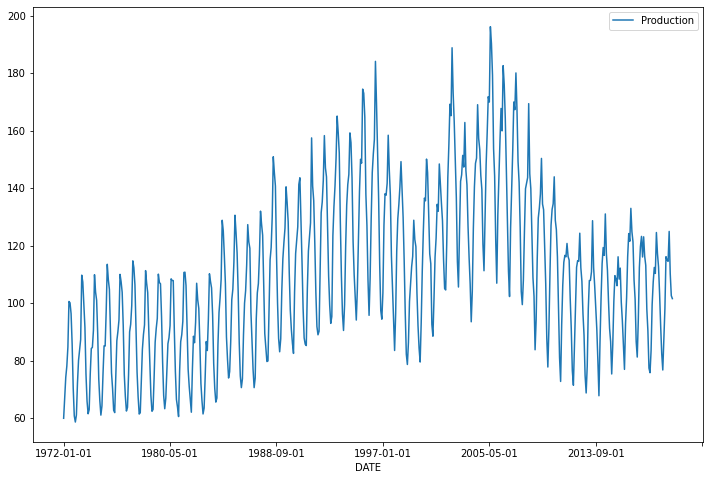

In [12]:
#CODE HERE
df.plot(figsize=(12,8))

## Train Test Split

**TASK: Figure out the length of the data set**

In [32]:
#CODE HERE

In [33]:
len(df)

573

**TASK: Split the data into a train/test split where the test set is the last 24 months of data.**

In [34]:
#CODE HERE
df['Production']

DATE
1972-01-01     59.9622
1972-02-01     67.0605
1972-03-01     74.2350
1972-04-01     78.1120
1972-05-01     84.7636
                ...   
2019-05-01    114.5613
2019-06-01    124.9605
2019-07-01    110.2632
2019-08-01    102.6085
2019-09-01    101.5866
Name: Production, Length: 573, dtype: float64

In [41]:
test=df.iloc[-24:]

In [42]:
type(test)

pandas.core.frame.DataFrame

In [43]:
len(test)

24

In [44]:
test

,Production
DATE,
2017-10-01,90.4732
2017-11-01,77.4378
2017-12-01,75.8118
2018-01-01,83.4343
2018-02-01,99.4899
2018-03-01,107.3152
2018-04-01,112.4309
2018-05-01,110.3544
2018-06-01,124.5841


In [45]:
train=df.iloc[:-24]

## Scale Data

**TASK: Use a MinMaxScaler to scale the train and test sets into scaled versions.**

In [46]:
# CODE HERE
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

**TASK: Create a TimeSeriesGenerator object based off the scaled_train data. The batch length is up to you, but at a minimum it should be at least 18 to capture a full year seasonality.**

In [47]:
#CODE HERE
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 18

batch_size = 1 

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)


In [48]:
# What does the first batch look like?
X,y = generator[0]

In [49]:
X

array([[[0.00947104],
        [0.06108982],
        [0.11326273],
        [0.14145625],
        [0.18982663],
        [0.30495972],
        [0.30154406],
        [0.27416065],
        [0.19736841],
        [0.08532665],
        [0.01561588],
        [0.        ],
        [0.01774221],
        [0.09850931],
        [0.15590133],
        [0.18358944],
        [0.20878908],
        [0.37150354]]])

In [50]:
y

array([[0.3542551]])

### Create the Model

**TASK: Create a Keras Sequential Model with as many LSTM units you want and a final Dense Layer.**

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

# define model
model = Sequential()

# Simple RNN layer
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


**TASK: Create a generator for the scaled test/validation set. NOTE: Double check that your batch length makes sense for the size of the test set as mentioned in the RNN Time Series video.**

**TASK: Create an EarlyStopping callback based on val_loss.**

In [62]:
#CODE HERE
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=3)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                           length=length, batch_size=batch_size)

**TASK: Fit the model to the generator, let the EarlyStopping dictate the amount of epochs, so feel free to set the parameter high.**

In [63]:
# CODE HERE
model.fit_generator(generator,epochs=20,
                    validation_data=validation_generator,
                    callbacks=[early_stop])

Epoch 1/20
  1/531 [..............................] - ETA: 32s - loss: 9.0241e-06

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


531/531 [==============================] - 8s 14ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 2/20
531/531 [==============================] - 6s 11ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 3/20
531/531 [==============================] - 5s 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 4/20
531/531 [==============================] - 5s 9ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 5/20
531/531 [==============================] - 5s 9ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 6/20
531/531 [==============================] - 5s 9ms/step - loss: 0.0019 - val_loss: 0.0022


**TASK: Plot the history of the loss that occured during training.**

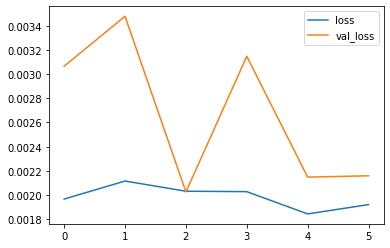

In [64]:
# CODE HERE
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluate on Test Data

**TASK: Forecast predictions for your test data range (the last 12 months of the entire dataset). Remember to inverse your scaling transformations. Your final result should be a DataFrame with two columns, the true test values and the predictions.**

In [65]:
# CODE HERE
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, batch_size))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [68]:
true_predictions = scaler.inverse_transform(test_predictions)

test['Predictions'] = true_predictions 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [69]:
test

,Production,Predictions
DATE,,
2017-10-01,90.4732,87.167252
2017-11-01,77.4378,80.147718
2017-12-01,75.8118,80.481037
2018-01-01,83.4343,90.429114
2018-02-01,99.4899,101.436154
2018-03-01,107.3152,106.745440
2018-04-01,112.4309,109.908018
2018-05-01,110.3544,114.730779
2018-06-01,124.5841,116.054004


**TASK: Plot your predictions versus the True test values. (Your plot may look different than ours).**

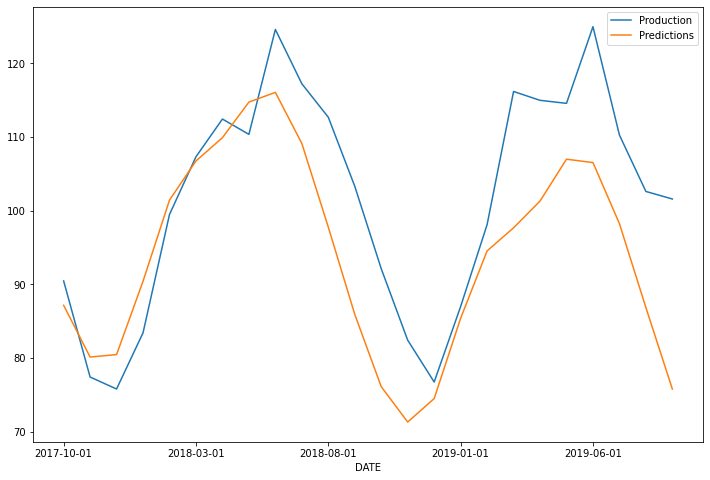

In [70]:
# CODE HERE
test.plot(figsize=(12,8))

**TASK: Calculate your RMSE.**

In [71]:
#CODE HERE
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())


In [72]:
rmse=rmse(test['Production'],test['Predictions'])

In [73]:
print("The RMSE is : ",rmse )

The RMSE is :  11.481830911347261
